  # Machine Learning and Predictive Modeling - Assignment 7
  ### Arpit Parihar
  ### 05/19/2021
  ****

  **Importing modules**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pretty_cm import pretty_plot_confusion_matrix

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import load_model

import random
import os
import glob

import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Seeting seed for reproducibility**

In [2]:
seed_value = 2
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

 ### 1\. Data Processing

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
X_train = train_datagen.flow_from_directory(
    './dataset_train/',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 88 images belonging to 4 classes.


 **Plotting training images**

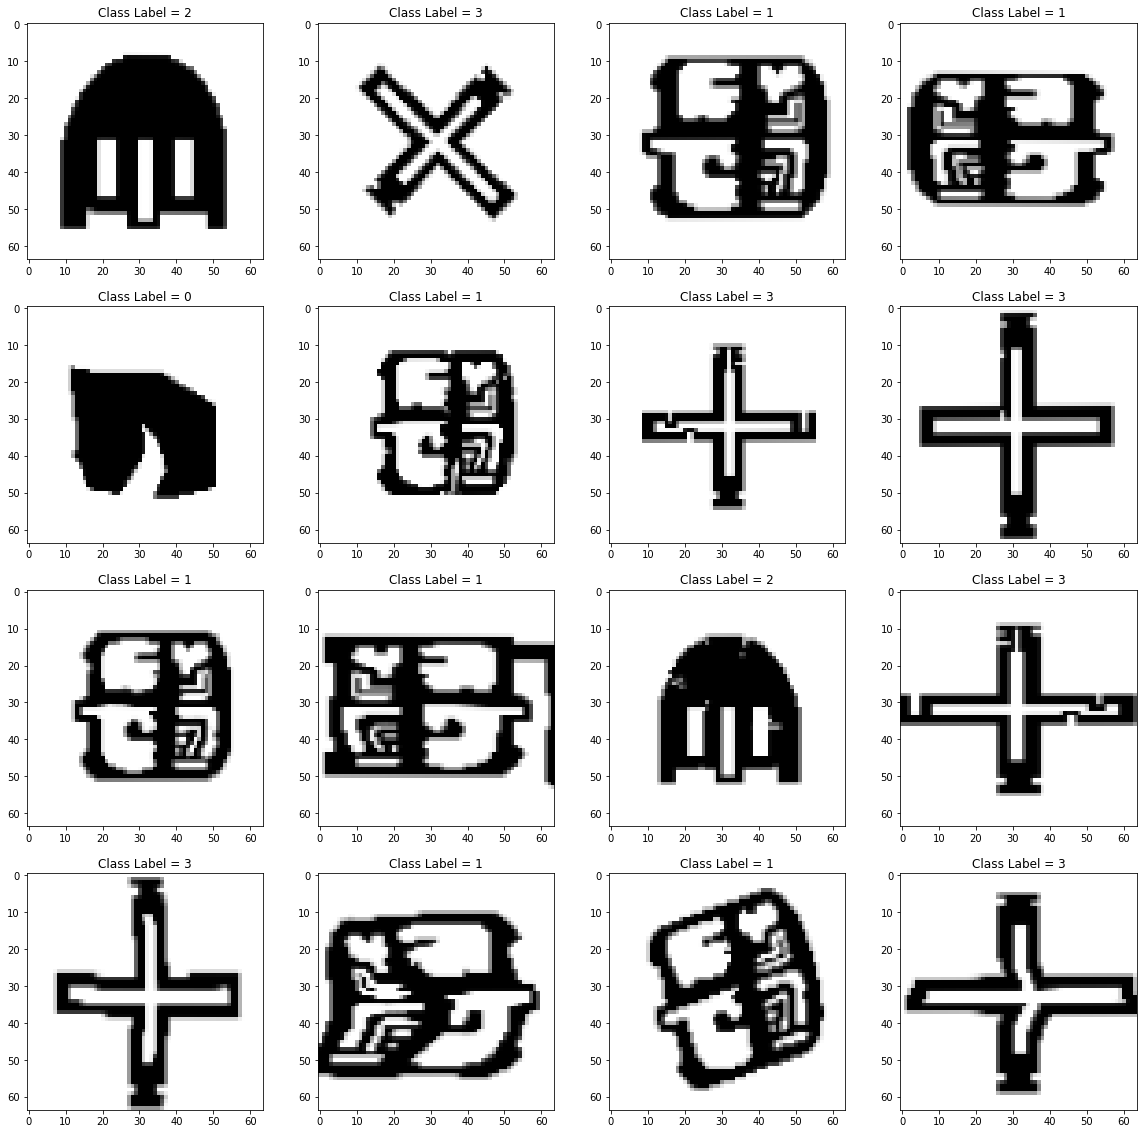

In [4]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20));

for i, ax in enumerate(axs.flatten()):
    img, label = X_train.next()
    _ = ax.set_title(f'Class Label = {np.argmax(label[i])}');
    _ = ax.imshow(img[i]);

 **Shape of training images**

In [5]:
img_shape = X_train.image_shape
img_shape

X_train.class_indices

(64, 64, 3)

{'category 1': 0, 'category 2': 1, 'category 3': 2, 'category 4': 3}

 ### 2\. Initial Classifier Build

In [6]:


def build_and_compile():
    classifier = Sequential()
    classifier.add(
        Conv2D(
            32, kernel_size=(3, 3),
            activation='relu',
            input_shape=img_shape))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(128, activation='relu'))
    classifier.add(Dense(4, activation='softmax'))

    classifier.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy'])
    return classifier



 ### 3\. Model Runs:
 
 **a) Use .fit() with the training set. For the first run, use the following parameters:**
- steps_per_epoch = 3
- epochs = 3

 **b) save model to a file.**

In [7]:
try:
    classifier = load_model('./Models/baseline_model.h5')
    print('Baseline model loaded from disk')
except:
    classifier = build_and_compile()
    steps_per_epoch = 3
    epochs = 3
    classifier.fit(
        X_train,
        steps_per_epoch=X_train.samples // 32 +
        min(X_train.samples % 32, 1),
        epochs=epochs)
    classifier.save('./Models/baseline_model.h5')
    print('Baseline model saved')

Baseline model loaded from disk


 **c) Predict using the model built in step 2.**

 Reading test data and creating labels

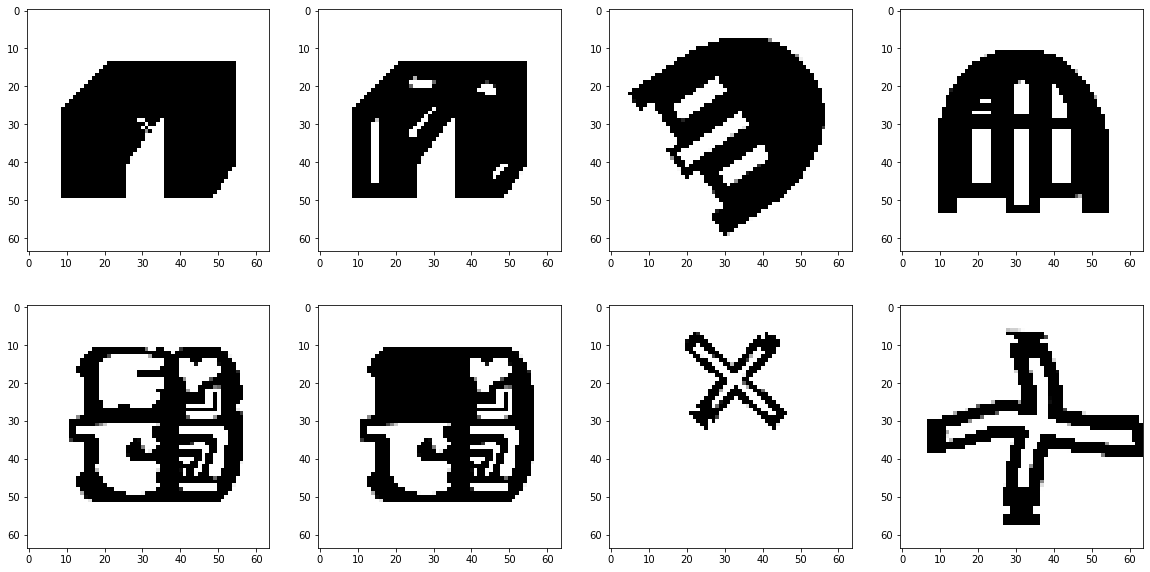

In [8]:
files = glob.glob(os.path.join('./dataset_test/', '*.png'))

X_test = []
fig, axs = plt.subplots(2, 4, figsize=(20, 10));

for (i, file) in enumerate(files):
    img = image.load_img(file, target_size = (64, 64))
    img = image.img_to_array(img);
    _ = axs.flatten()[i].imshow(img.astype(np.uint8))
    img = np.expand_dims(img, axis = 0)
    X_test.append(img)

y_test = [0, 0, 2, 2, 1, 1, 3, 3]


**d) Determine accuracy.**

 Creating functions for predictions and classification report

In [9]:

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def classification_results(act, pred, labels, header=None):
    print(color.UNDERLINE + color.BOLD + header + ':\n' + color.END)
    print('Confusion Matrix:\n')
    plt.pause(1)
    pretty_plot_confusion_matrix(pd.DataFrame(confusion_matrix(
        act, pred), columns=labels, index=labels), pred_val_axis='x')
    plt.show()
    print('\n' + '-' * 75 + '\n')
    print(classification_report(act, pred, digits=4))
    print('\n' + '-' * 75 + '\n')

def predict_test(model):
    y_pred = []
    for i in X_test:
        y_pred.append(np.argmax(model.predict(i)))
    return y_pred, accuracy_score(y_test, y_pred)

Baseline:

Confusion Matrix:



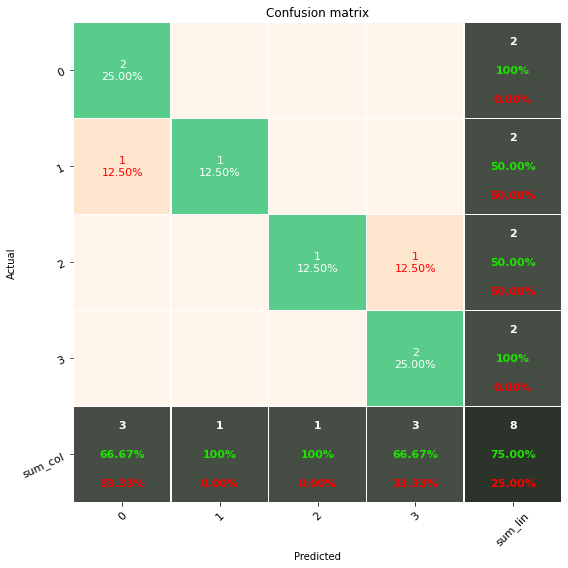


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.6667    1.0000    0.8000         2
           1     1.0000    0.5000    0.6667         2
           2     1.0000    0.5000    0.6667         2
           3     0.6667    1.0000    0.8000         2

    accuracy                         0.7500         8
   macro avg     0.8333    0.7500    0.7333         8
weighted avg     0.8333    0.7500    0.7333         8


---------------------------------------------------------------------------



In [10]:
classification_results(y_test, predict_test(classifier)[0], range(4), 'Baseline')

**e) Run this process for the following combinations:**

* (steps_per_epoch: 1, epochs: 1)
* (steps_per_epoch: 1, epochs: 2)
* (steps_per_epoch: 1, epochs: 3)
* (steps_per_epoch: 2, epochs: 4)
* (steps_per_epoch: 2, epochs: 5)
* (steps_per_epoch: 2, epochs: 6)
* (steps_per_epoch: 3, epochs: 7)
* (steps_per_epoch: 3, epochs: 8)
* (steps_per_epoch: 5, epochs: 9)
* (steps_per_epoch: 5, epochs: 10)

In [11]:
models = {}

for (i, j) in zip([1] * 3 + [2] * 3 + [3] * 2 + [5] * 2, range(1, 11)):
    try:
        models[f'{i}_{j}'] = load_model(f'./Models/model_{i}_{j}.h5')
        print(f'Model_{i}_{j} loaded from disk')
    except:
        classifier = build_and_compile()
        classifier.fit(
            train_datagen.flow_from_directory(
                './dataset_train/',
                target_size=(64, 64),
                batch_size=X_train.samples // i +
                min(X_train.samples % i, 1),
                class_mode='categorical'),
            epochs=j,
            verbose=0)
        models[f'{i}_{j}'] = classifier
        classifier.save(f'./Models/model_{i}_{j}.h5')
        print(f'Model_{i}_{j} saved to disk')

Model_1_1 loaded from disk
Model_1_2 loaded from disk
Model_1_3 loaded from disk
Model_2_4 loaded from disk
Model_2_5 loaded from disk
Model_2_6 loaded from disk
Model_3_7 loaded from disk
Model_3_8 loaded from disk
Model_5_9 loaded from disk
Model_5_10 loaded from disk


In [12]:
pd.DataFrame({
    'steps':[eval(x.replace('_', ','))[0] for x in models],
    'epochs':[eval(x.replace('_', ','))[1] for x in models],
    'accuracy':[predict_test(models[x])[1] for x in models]
})


,steps,epochs,accuracy
0,1,1,0.375
1,1,2,0.250
2,1,3,0.250
3,2,4,0.750
4,2,5,0.625
5,2,6,0.750
6,3,7,0.875
7,3,8,0.625
8,5,9,0.625
9,5,10,1.000


**Printing predictions of the best model**

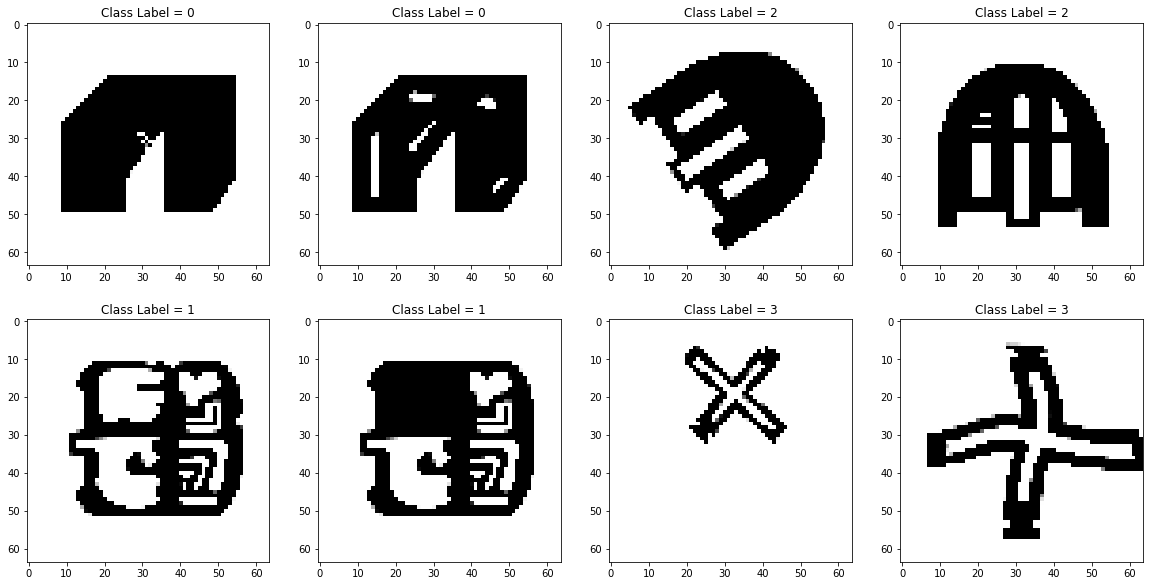

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10));

for (i, file) in enumerate(files):
    img = image.load_img(file, target_size = (64, 64))
    img = image.img_to_array(img);
    _ = axs.flatten()[i].imshow(img.astype(np.uint8))
    img = np.expand_dims(img, axis = 0)
    _ = axs.flatten()[i].set_title(f'Class Label = {np.argmax(models["5_10"].predict(img))}');

### Conceptual Questions: 

**4\. Discuss the effect of the following on accuracy and loss (train & test):**

- Increasing the steps_per_epoch
        
        Accuracy and loss jump around if the batch size is small, and steps per epoch are low. Increasing the steps per epoch reduces the batch size, and makes the gradient updates erratic, like in stochastic gradient descent

- Increasing the number of epochs

        Increasing the number of epochs reduces training loss and increases training accuracy, but it leads to overfitting, and will decrease test accuracy after a point. The test sample in this assignment was too small to demonstrate this effect

**5\. Name two uses of zero padding in CNN.**

Zero padding maintains the size od the image after convolutions, and is useful if smaller images are passed through too many convolutional layers. It also makes sure that the information at the edges of the image isn't lost, as the filter goes over edge pixels more than once

**6\. What is the use of a 1 x 1 kernel in CNN?**

A convolutional layers with 1x1 filters is used for dimensionality reduction. It reduces the number of feature maps to the number of selected features, without losing too much information.

**7\. What are the advantages of a CNN over a fully connected DNN for this image classification problem?**

CNN has a lot fewer parameters due to parameter sharing between filters, and is a lot better than feature extraction from images compared to a fully connected ANN.